In [39]:
import numpy as np

import pandas as pd
from pandas.plotting import scatter_matrix

from scipy import stats
import scipy as sc

import matplotlib.pyplot as plt
import seaborn as sns

from random import randrange

import re

import random
import pickle,pprint

from scipy.stats import gamma
from scipy.optimize import minimize

from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.integrate import odeint
%matplotlib inline

In [2]:


rc('text', usetex=True)

# this is just to have figure with large fontsize
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (8, 5),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)


plt.rc('font', weight='bold')
plt.rc('xtick.major', size=5, pad=7)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=20)
plt.rc('axes', titlesize=20)


## Poisson Process with absolute refractory period

In [3]:
def RHO(tau,nu,d):
    if tau< d:
        return 0 
    else:
        return nu

def S(tau,nu,d):
    if tau <d:
        return 1
    else:
        return np.exp(-nu*(tau-d))
    
def P(tau,nu,d):
    if tau <d:
        return 0
    else:
        return nu*np.exp(-nu*(tau-d))
    
    
    

In [4]:
def phih(h,nu_max,beta,h_0):
    return nu_max/(1+np.exp(-beta*(h-h_0)))

def phih_prime(h,nu_max,beta,h_0):
    return beta*phih(h,nu_max,beta,h_0)/(1+np.exp(beta*(h-h_0)))


In [5]:
def Cnm(n,m,h,nu_max,beta,h_0,d):
    
    nu=phih(h,nu_max,beta,h_0)
    
    ln=eigenvalue(n,nu,d)
    lm=eigenvalue(m,nu,d)
    
    if n==m:
        return ln*d*(1+0.5*d*(ln+nu))/(nu*(1+(ln+nu)*d)**2)*phih_prime(h,nu_max,beta,h_0)
    else:
        
        return (ln*(nu+lm))/((ln-lm)*nu*(ln+nu)*(1+d*(lm+nu)))*phih_prime(h,nu_max,beta,h_0)
    

def eigenvalue(n,nu,d):
    return (1/d)*sc.special.lambertw(d*nu*np.exp(nu*d), k=n)-nu

In [6]:
def phi1_0h(h,nu_max,beta,h_0,d):
    nu=phih(h,nu_max,beta,h_0)
    l1=eigenvalue(1,nu,d)
    return (nu+l1)/(1+d*(nu+l1))

In [7]:
def RMS(A_n,A_th):
    return  np.sqrt(np.sum((A_n-A_th)**2)/len(A_n))

def NRMS(A_n,A_th):
    return RMS(A_n,A_th)/(np.amax(A_th)-np.amin(A_th))

# Non constant input

TODO be carefull of the of f_cos(wt)

In [66]:
epsilon_vec=np.copy([1,2,3,4,5,6,7,8,9,10]) #mV
mu1_vec=np.copy([10,15,20,30])#  #mV

In [68]:
#MU 
fr1=0.005 #kHz
fr2=0.02  #kHz
fr3=0.1  #kHz

w1=2*np.pi*fr1
w2=2*np.pi*fr2
w3=2*np.pi*fr3

#mu_1=5 #mV
h_0=15 #mV

#TIME PARAMETER
dt=0.01
nu_max=0.1 #kHz

t_max=200
N_sim=int(t_max/dt)
tsim=[i*dt for i in range(N_sim)]
tsim_num=[i*dt for i in range(N_sim)]

mu_Matrix  =np.zeros((len(mu1_vec),len(epsilon_vec),N_sim))
A_Matrix   =np.zeros((len(mu1_vec),len(epsilon_vec),N_sim))
A_wc_Matrix=np.zeros((len(mu1_vec),len(epsilon_vec),N_sim))


d=10 #ms

for i_o, mu_1 in enumerate(mu1_vec):
    for i_e, epsilon in enumerate(epsilon_vec):
        
        
        def mu(t):
            return mu_1 + epsilon/3*(np.cos(w1*t)-np.cos(w2*t)-np.cos(w3*t))
            
        
        print(i_o,i_e)
        # H PARMETER
        h=np.zeros((N_sim+1,1))

        h[0]=h_0  
        tau_m=10 #ms

        #NU PARAMETER
        beta=1 # mV^{-1}
        nu_0=phih(h[0],nu_max,beta,h_0)
        
    
        A=np.zeros((N_sim,1))

        A_wc=np.zeros((N_sim+1,1))
        A_wc[0]=nu_0/(1+d*nu_0)
    
        U=np.zeros((N_sim+1,1))
    
        V=np.zeros((N_sim+1,1))
    
        d_index=int(d/dt)

        for i in range(N_sim):
            t=i*dt
        
              
            mu_Matrix[i_o,i_e,i]=mu(t)
            if i<d_index:
                jstart=0
                first_A=d_index-i-1
            else:
                jstart=i-d_index+1
                first_A=0
            
    
    
            hpoint=1/tau_m*(-h[i]+mu(i*dt))
        

            h[i+1]=h[i]+dt*hpoint
            nu=phih(h[i],nu_max,beta,h_0)
        
            A_wc[i+1]=nu*(1-(np.sum(A_wc[jstart:i+1])+first_A*A_wc[0])*dt)
    
        
            l1=eigenvalue(1,nu,d)
            phi1_0= phi1_0h(h[i],nu_max,beta,h_0,d)

 
            A_inf=nu/(d*nu+1)
    
        
            f=l1+(Cnm(1,1,h[i],nu_max,beta,h_0,d)+Cnm(1,-1,h[i],nu_max,beta,h_0,d))*hpoint
            g=l1+(Cnm(1,1,h[i],nu_max,beta,h_0,d)-Cnm(1,-1,h[i],nu_max,beta,h_0,d))*hpoint
    
            c10=Cnm(1,0,h[i],nu_max,beta,h_0,d)*hpoint
    
            K1=(f.real*U[i]-g.imag*V[i]+c10.real)
            L1=(g.real*V[i]+f.imag*U[i]+c10.imag)
    
            K2=(f.real*(U[i]+0.5*dt*K1)-g.imag*(V[i]+0.5*dt*L1)+c10.real)
            L2=(g.real*(V[i]+0.5*dt*L1)+f.imag*(U[i]+0.5*dt*K1)+c10.imag)
    
            K3=(f.real*(U[i]+0.5*dt*K2)-g.imag*(V[i]+0.5*dt*L2)+c10.real)
            L3=(g.real*(V[i]+0.5*dt*L2)+f.imag*(U[i]+0.5*dt*K2)+c10.imag)
    
            K4=(f.real*(U[i]+dt*K3)-g.imag*(V[i]+dt*L3)+c10.real)
            L4=(g.real*(V[i]+dt*L3)+f.imag*(U[i]+dt*K3)+c10.imag)
    
    
            U[i+1]=U[i]+dt/6*(K1+2*K2+2*K3+K4)
            V[i+1]=V[i]+dt/6*(L1+2*L2+2*L3+L4)
         
    
            A[i]=A_inf+2*(U[i]*phi1_0.real-V[i]*phi1_0.imag)
        
        
        A_wc=A_wc[:-1]
    
        #plt.figure()
        #plt.plot(tsim,A,label='$A_{ODE}$')
        #plt.plot(tsim_num,A_wc,label='$A_{num}$',c='k',ls='--')
        #plt.legend()
        #plt.ylabel('A')
        #plt.xlabel('t')
        #plt.gca().set_ylim(bottom=0)
        
    
        A_Matrix[i_o,i_e,:]=A.flatten()
        A_wc_Matrix[i_o,i_e,:]=A_wc.flatten()
    

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9


In [69]:
mu1_search  = {'mu1_vec': mu1_vec,
               'epsilon_vec': epsilon_vec,
               'mu_Matrix': mu_Matrix,
               'A_Matrix': A_Matrix,
               'A_wc_Matrix': A_wc_Matrix,
                'tsim':tsim
              }

output = open('mu1_search3.pkl', 'wb')

#pickle.dump(mu1_search , output)

output.close()

In [70]:
NRMS_matrix=np.zeros((len(mu1_vec),len(epsilon_vec)))


for i_o, mu_1 in enumerate(mu1_vec):
    for i_e, epsilon in enumerate(epsilon_vec):
        NRMS_matrix[i_o,i_e]=NRMS(A_Matrix[i_o,i_e,:],A_wc_Matrix[i_o,i_e,:])

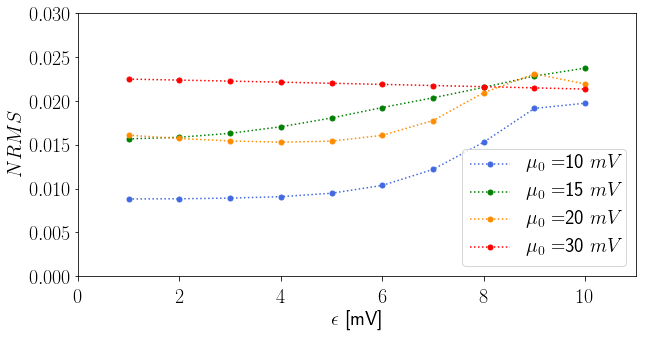

In [82]:
plt.figure(figsize=(10, 5))
colorv=['royalblue','g','darkorange','r']
for i_o, mu_1 in enumerate(mu1_vec):
    plt.plot(epsilon_vec,NRMS_matrix[i_o,:],c=colorv[i_o],label=r'$\mu_0=$'+str(mu1_vec[i_o])+r' $mV$',ls=':',marker='o',ms='5')

plt.ylabel(r'$NRMS$ ')
plt.xlabel(r'$\epsilon$ [mV]')
    
plt.legend(loc='lower right',fontsize='20')#, bbox_to_anchor=(1.05, 0.5))
plt.ylim(0,0.03)
plt.xlim(0,11)

plt.gcf().subplots_adjust(bottom=0.15)

plt.savefig('NRMSe.pdf')


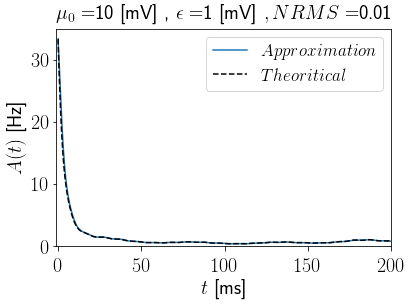

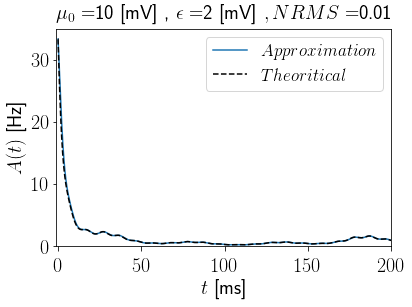

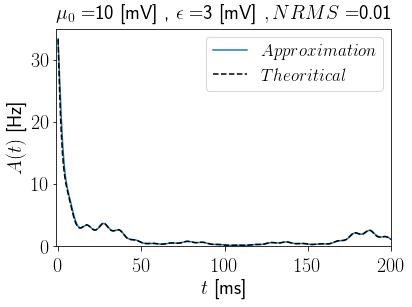

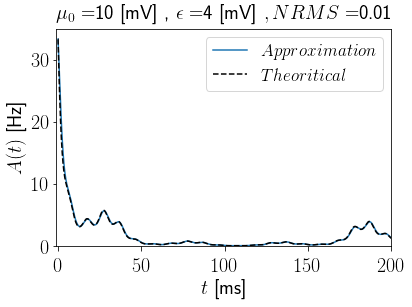

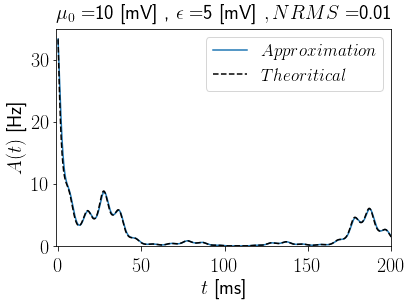

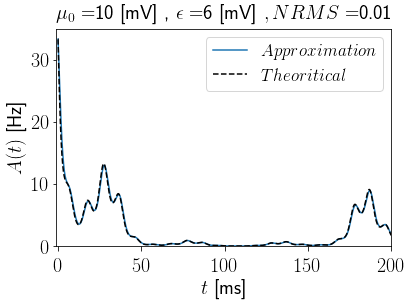

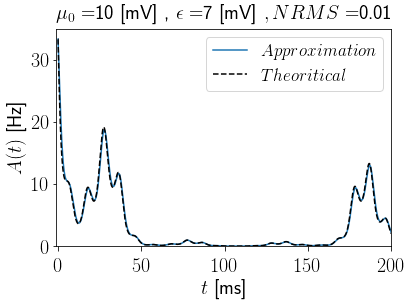

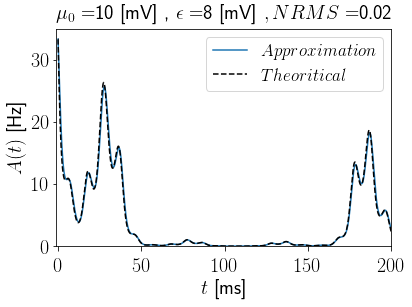

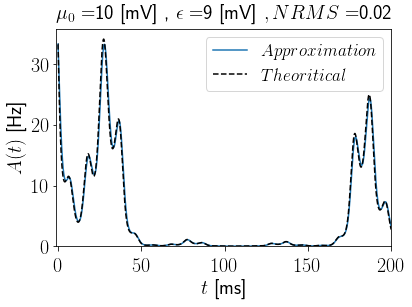

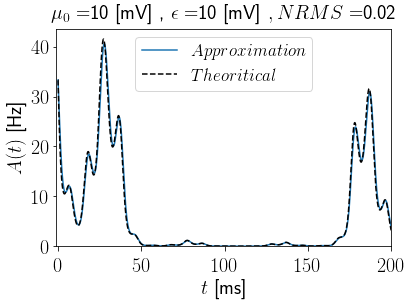

In [72]:



i_o=0
for i_e, epsilon in enumerate(epsilon_vec):

    plt.figure()
    plt.plot(tsim,1000*A_Matrix[i_o,i_e,:],label='$Approximation$')
    plt.plot(tsim_num,1000*A_wc_Matrix[i_o,i_e,:],label='$Theoritical$',c='k',ls='--')
    plt.title(r'$\mu_{0}=$'+str(mu1_vec[i_o])+' [mV] , $\epsilon=$'+str(epsilon_vec[i_e])+ r' [mV] $, NRMS=$'+str(np.round(NRMS_matrix[i_o,i_e],2)))

    plt.legend()
    plt.ylabel(r'$A(t)$ [Hz]')
    plt.xlabel(r'$t$ [ms]')
    plt.xlim(-1,t_max)
    plt.gca().set_ylim(bottom=0)
        

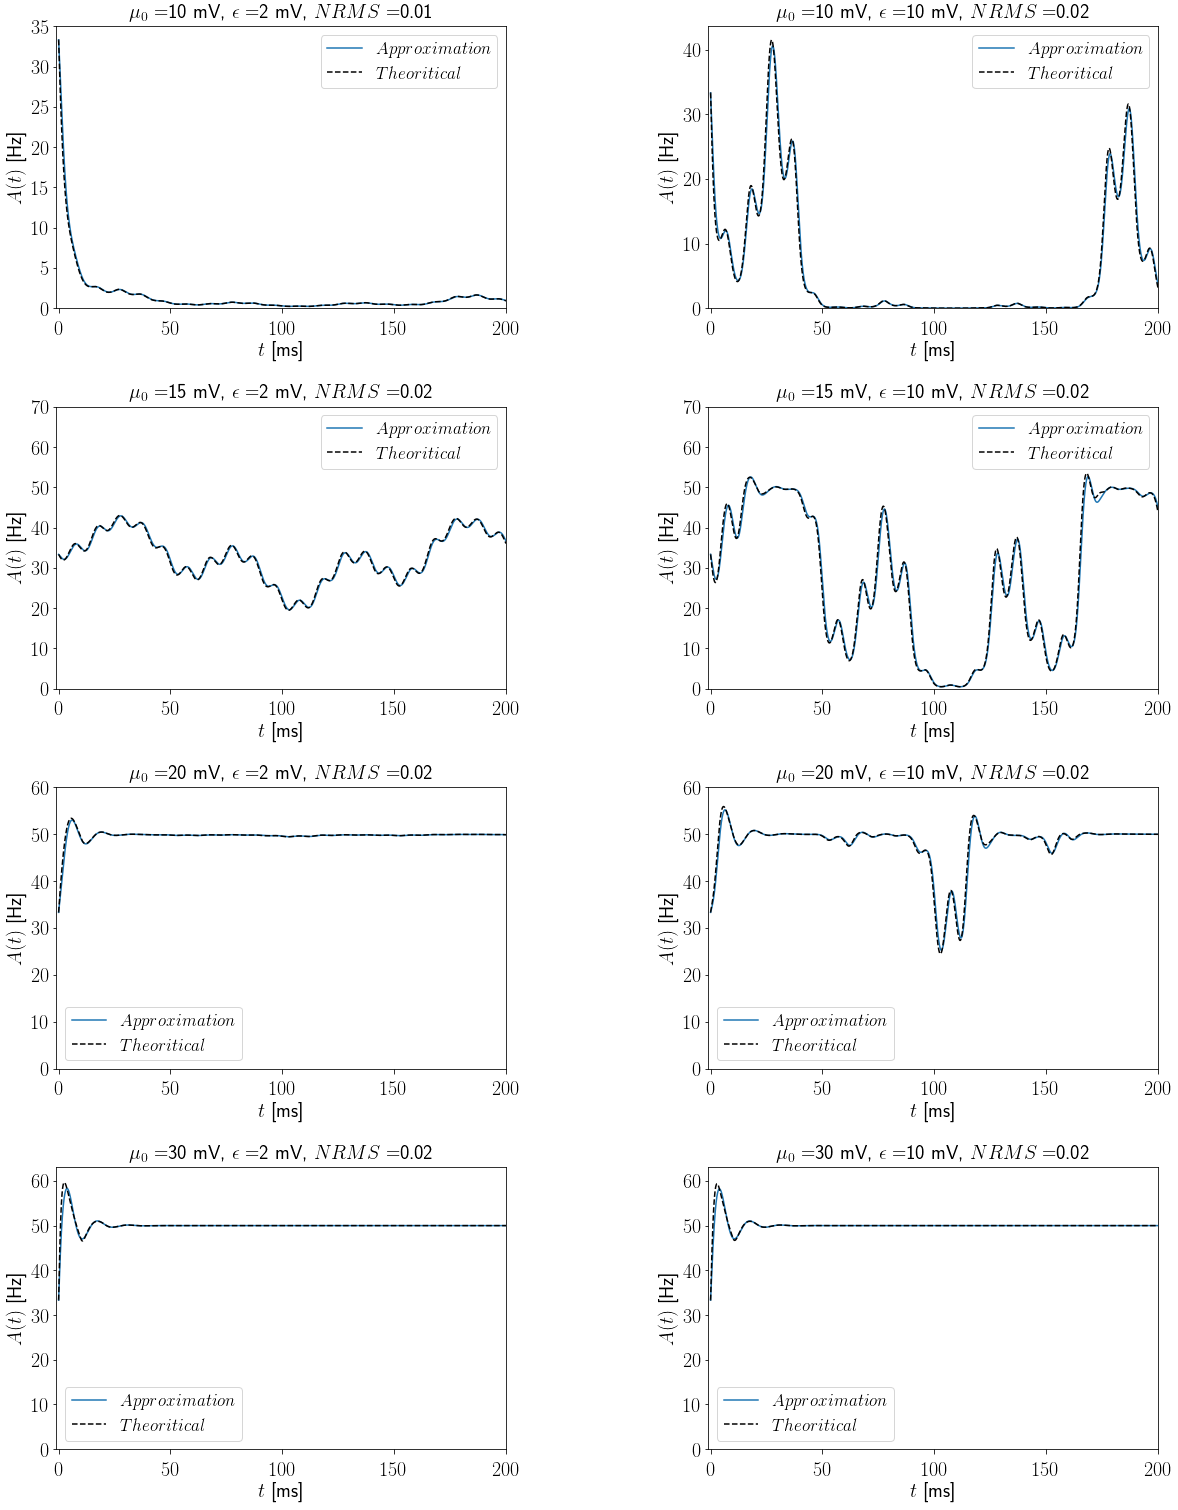

In [83]:
plt.figure(figsize=(18,26))

plt.subplot(421)
i_e=1
i_o=0
plt.plot(tsim,1000*A_Matrix[i_o,i_e,:],label='$Approximation$')
plt.plot(tsim_num,1000*A_wc_Matrix[i_o,i_e,:],label='$Theoritical$',c='k',ls='--')
plt.title(r'$\mu_{0}=$'+str(mu1_vec[i_o])+' mV, $\epsilon=$'+str(epsilon_vec[i_e])+ r' mV, $NRMS=$'+str(np.round(NRMS_matrix[i_o,i_e],2)))
plt.legend()
plt.ylabel(r'$A(t)$ [Hz]')
plt.xlabel(r'$t$ [ms]')
plt.xlim(-1,t_max)
plt.gca().set_ylim(bottom=0)

plt.subplot(422)
i_e=9
i_o=0
plt.plot(tsim,1000*A_Matrix[i_o,i_e,:],label='$Approximation$')
plt.plot(tsim_num,1000*A_wc_Matrix[i_o,i_e,:],label='$Theoritical$',c='k',ls='--')
plt.title(r'$\mu_{0}=$'+str(mu1_vec[i_o])+' mV, $\epsilon=$'+str(epsilon_vec[i_e])+ r' mV, $NRMS=$'+str(np.round(NRMS_matrix[i_o,i_e],2)))
plt.legend()
plt.ylabel(r'$A(t)$ [Hz]')
plt.xlabel(r'$t$ [ms]')
plt.xlim(-1,t_max)
plt.gca().set_ylim(bottom=0)

plt.subplot(423)
i_e=1
i_o=1
plt.plot(tsim,1000*A_Matrix[i_o,i_e,:],label='$Approximation$')
plt.plot(tsim_num,1000*A_wc_Matrix[i_o,i_e,:],label='$Theoritical$',c='k',ls='--')
plt.title(r'$\mu_{0}=$'+str(mu1_vec[i_o])+' mV, $\epsilon=$'+str(epsilon_vec[i_e])+ r' mV, $NRMS=$'+str(np.round(NRMS_matrix[i_o,i_e],2)))
plt.legend()
plt.ylabel(r'$A(t)$ [Hz]')
plt.xlabel(r'$t$ [ms]')
plt.xlim(-1,t_max)
plt.gca().set_ylim(bottom=0)
plt.ylim(0,70)

plt.subplot(424)
i_e=9
i_o=1
plt.plot(tsim,1000*A_Matrix[i_o,i_e,:],label='$Approximation$')
plt.plot(tsim_num,1000*A_wc_Matrix[i_o,i_e,:],label='$Theoritical$',c='k',ls='--')
plt.title(r'$\mu_{0}=$'+str(mu1_vec[i_o])+' mV, $\epsilon=$'+str(epsilon_vec[i_e])+ r' mV, $NRMS=$'+str(np.round(NRMS_matrix[i_o,i_e],2)))
plt.legend()
plt.ylabel(r'$A(t)$ [Hz]')
plt.xlabel(r'$t$ [ms]')
plt.xlim(-1,t_max)
plt.ylim(0,70)
plt.gca().set_ylim(bottom=0)

plt.subplot(425)
i_e=1
i_o=2
plt.plot(tsim,1000*A_Matrix[i_o,i_e,:],label='$Approximation$')
plt.plot(tsim_num,1000*A_wc_Matrix[i_o,i_e,:],label='$Theoritical$',c='k',ls='--')
plt.title(r'$\mu_{0}=$'+str(mu1_vec[i_o])+' mV, $\epsilon=$'+str(epsilon_vec[i_e])+ r' mV, $NRMS=$'+str(np.round(NRMS_matrix[i_o,i_e],2)))
plt.legend()
plt.ylabel(r'$A(t)$ [Hz]')
plt.xlabel(r'$t$ [ms]')
plt.xlim(-1,t_max)
plt.gca().set_ylim(bottom=0)
plt.ylim(0,60)


plt.subplot(426)
i_e=9
i_o=2
plt.plot(tsim,1000*A_Matrix[i_o,i_e,:],label='$Approximation$')
plt.plot(tsim_num,1000*A_wc_Matrix[i_o,i_e,:],label='$Theoritical$',c='k',ls='--')
plt.title(r'$\mu_{0}=$'+str(mu1_vec[i_o])+' mV, $\epsilon=$'+str(epsilon_vec[i_e])+ r' mV, $NRMS=$'+str(np.round(NRMS_matrix[i_o,i_e],2)))
plt.legend()
plt.ylabel(r'$A(t)$ [Hz]')
plt.xlabel(r'$t$ [ms]')
plt.xlim(-1,t_max)
plt.gca().set_ylim(bottom=0)
plt.ylim(0,60)


plt.subplot(427)
i_e=1
i_o=3
plt.plot(tsim,1000*A_Matrix[i_o,i_e,:],label='$Approximation$')
plt.plot(tsim_num,1000*A_wc_Matrix[i_o,i_e,:],label='$Theoritical$',c='k',ls='--')
plt.title(r'$\mu_{0}=$'+str(mu1_vec[i_o])+' mV, $\epsilon=$'+str(epsilon_vec[i_e])+ r' mV, $NRMS=$'+str(np.round(NRMS_matrix[i_o,i_e],2)))
plt.legend()
plt.ylabel(r'$A(t)$ [Hz]')
plt.xlabel(r'$t$ [ms]')
plt.xlim(-1,t_max)
plt.gca().set_ylim(bottom=0)
plt.ylim(0,63)

plt.subplot(428)
i_e=9
i_o=3
plt.plot(tsim,1000*A_Matrix[i_o,i_e,:],label='$Approximation$')
plt.plot(tsim_num,1000*A_wc_Matrix[i_o,i_e,:],label='$Theoritical$',c='k',ls='--')
plt.title(r'$\mu_{0}=$'+str(mu1_vec[i_o])+' mV, $\epsilon=$'+str(epsilon_vec[i_e])+ r' mV, $NRMS=$'+str(np.round(NRMS_matrix[i_o,i_e],2)))
plt.legend()
plt.ylabel(r'$A(t)$ [Hz]')
plt.xlabel(r'$t$ [ms]')
plt.xlim(-1,t_max)
plt.gca().set_ylim(bottom=0)
plt.ylim(0,63)

plt.subplots_adjust(top=0.88, bottom=0.12, left=0.10, right=0.95, hspace=0.35,
                    wspace=0.45)
plt.savefig('A_t.pdf')


In [84]:
#MU 
fr1=0.005 #kHz
fr2=0.02  #kHz
fr3=0.1  #kHz

w1=2*np.pi*fr1
w2=2*np.pi*fr2
w3=2*np.pi*fr3

fcos=[1/3*(np.cos(w1*t)-np.cos(w2*t)-np.cos(w3*t)) for t in tsim ]

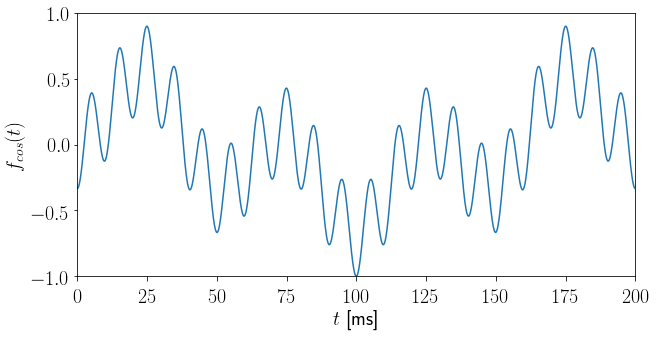

In [87]:
plt.figure(figsize=(10, 5))
plt.plot(tsim,fcos)
plt.ylabel(r'$f_{cos}(t)$')
plt.xlabel(r'$t$ [ms]')
plt.ylim(-1,1)
plt.xlim(0,t_max)

plt.gcf().subplots_adjust(bottom=0.15)

plt.savefig('fcos.pdf')

# Omega search

In [8]:
fr_vec=np.logspace(-4,1,50)
omega_vec=2*np.pi*fr_vec #kHz
epsilon_vec=np.copy([5])#  #mV

mu_1=15 #mV
h_0=15 #mV
#epsilon=4 #mV

#TIME PARAMETER
dt=0.01
nu_max=0.1 #kHz

t_max=200
N_sim=int(t_max/dt)
tsim=[i*dt for i in range(N_sim)]
tsim_num=[i*dt for i in range(N_sim)]

mu_Matrix  =np.zeros((len(omega_vec),len(epsilon_vec),N_sim))
A_Matrix   =np.zeros((len(omega_vec),len(epsilon_vec),N_sim))
A_wc_Matrix=np.zeros((len(omega_vec),len(epsilon_vec),N_sim))

d=10 #ms

for i_o, omega in enumerate(omega_vec):
    for i_e, epsilon in enumerate(epsilon_vec):
        
        def mu(t):
            return mu_1 + epsilon*np.cos(omega*t)
            
        
        print(i_o,i_e,omega,epsilon)
        # H PARMETER
        h=np.zeros((N_sim+1,1))

        h[0]=h_0  
        tau_m=10 #ms

        #NU PARAMETER
        beta=1 # mV^{-1}
        nu_0=phih(h[0],nu_max,beta,h_0)
        
    
        A=np.zeros((N_sim,1))

        A_wc=np.zeros((N_sim+1,1))
        A_wc[0]=nu_0/(1+d*nu_0)
    
        U=np.zeros((N_sim+1,1))
    
        V=np.zeros((N_sim+1,1))
    
        d_index=int(d/dt)

        for i in range(N_sim):
            t=i*dt
        
              
            mu_Matrix[i_o,i_e,i]=mu(t)
            if i<d_index:
                jstart=0
                first_A=d_index-i-1
            else:
                jstart=i-d_index+1
                first_A=0
            
    
    
            hpoint=1/tau_m*(-h[i]+mu(i*dt))
        

            h[i+1]=h[i]+dt*hpoint
            nu=phih(h[i],nu_max,beta,h_0)
        
            A_wc[i+1]=nu*(1-(np.sum(A_wc[jstart:i+1])+first_A*A_wc[0])*dt)
    
        
            l1=eigenvalue(1,nu,d)
            phi1_0= phi1_0h(h[i],nu_max,beta,h_0,d)

 
            A_inf=nu/(d*nu+1)
    
        
            f=l1+(Cnm(1,1,h[i],nu_max,beta,h_0,d)+Cnm(1,-1,h[i],nu_max,beta,h_0,d))*hpoint
            g=l1+(Cnm(1,1,h[i],nu_max,beta,h_0,d)-Cnm(1,-1,h[i],nu_max,beta,h_0,d))*hpoint
    
            c10=Cnm(1,0,h[i],nu_max,beta,h_0,d)*hpoint
    
            K1=(f.real*U[i]-g.imag*V[i]+c10.real)
            L1=(g.real*V[i]+f.imag*U[i]+c10.imag)
    
            K2=(f.real*(U[i]+0.5*dt*K1)-g.imag*(V[i]+0.5*dt*L1)+c10.real)
            L2=(g.real*(V[i]+0.5*dt*L1)+f.imag*(U[i]+0.5*dt*K1)+c10.imag)
    
            K3=(f.real*(U[i]+0.5*dt*K2)-g.imag*(V[i]+0.5*dt*L2)+c10.real)
            L3=(g.real*(V[i]+0.5*dt*L2)+f.imag*(U[i]+0.5*dt*K2)+c10.imag)
    
            K4=(f.real*(U[i]+dt*K3)-g.imag*(V[i]+dt*L3)+c10.real)
            L4=(g.real*(V[i]+dt*L3)+f.imag*(U[i]+dt*K3)+c10.imag)
    
    
            U[i+1]=U[i]+dt/6*(K1+2*K2+2*K3+K4)
            V[i+1]=V[i]+dt/6*(L1+2*L2+2*L3+L4)
         
    
            A[i]=A_inf+2*(U[i]*phi1_0.real-V[i]*phi1_0.imag)
        
        
        A_wc=A_wc[:-1]
    
        #plt.figure()
        #plt.plot(tsim,A,label='$A_{ODE}$')
        #plt.plot(tsim_num,A_wc,label='$A_{num}$',c='k',ls='--')
        #plt.legend()
        #plt.ylabel('A')
        #plt.xlabel('t')
        #plt.gca().set_ylim(bottom=0)
        
    
        A_Matrix[i_o,i_e,:]=A.flatten()
        A_wc_Matrix[i_o,i_e,:]=A_wc.flatten()
    

0 0 0.000628318530718 5
1 0 0.000794731971425 5
2 0 0.00100522088006 5
3 0 0.00127145887423 5
4 0 0.00160821139009 5
5 0 0.00203415456656 5
6 0 0.00257291101541 5
7 0 0.00325435992035 5
8 0 0.00411629412277 5
9 0 0.0052065160953 5
10 0 0.00658548904478 5
11 0 0.00832969017384 5
12 0 0.0105358520712 5
13 0 0.0133263274562 5
14 0 0.0168558748045 5
15 0 0.0213202411812 5
16 0 0.0269670182826 5
17 0 0.0341093737578 5
18 0 0.0431434193412 5
19 0 0.0545701790267 5
20 0 0.0690233756267 5
21 0 0.0873045767464 5
22 0 0.110427649353 5
23 0 0.139674988369 5
24 0 0.176668637703 5
25 0 0.223460248053 5
26 0 0.28264486051 5
27 0 0.357504826333 5
28 0 0.452191844639 5
29 0 0.571957213711 5
30 0 0.72344306558 5
31 0 0.915050735597 5
32 0 1.15740669661 5
33 0 1.46395189823 5
34 0 1.8516871957 5
35 0 2.34211620946 5
36 0 2.96243790602 5
37 0 3.74705504004 5
38 0 4.73948211524 5
39 0 5.99475867865 5
40 0 7.58250178848 5
41 0 9.59076694397 5
42 0 12.1309316027 5
43 0 15.343872123 5
44 0 19.4077767016 5
45

In [9]:
omega_search  = {'epsilon_vec': epsilon_vec,
               'omega_vec': omega_vec,
               'mu_Matrix': mu_Matrix,
               'A_Matrix': A_Matrix,
               'A_wc_Matrix': A_wc_Matrix,
                'tsim':tsim,
                'fr_vec':fr_vec,
                 'mu_1':mu_1
              }

output = open('omega_search4.pkl', 'wb')

pickle.dump(omega_search, output)

output.close()

In [91]:
pkl_file = open('omega_search4.pkl', 'rb')

omega_search = pickle.load(pkl_file)

pkl_file.close()

omega_vec=omega_search['omega_vec']
fr_vec=omega_search['fr_vec']
A_Matrix=omega_search['A_Matrix']
A_wc_Matrix=omega_search['A_wc_Matrix']
tsim=omega_search['tsim']
epsilon_vec=omega_search['epsilon_vec']

In [92]:
NRMS_matrix=np.zeros((len(omega_vec),len(epsilon_vec)))

for i_o, omega in enumerate(omega_vec):
    for i_e, epsilon in enumerate(epsilon_vec):
        NRMS_matrix[i_o,i_e]=NRMS(A_Matrix[i_o,i_e,:],A_wc_Matrix[i_o,i_e,:])

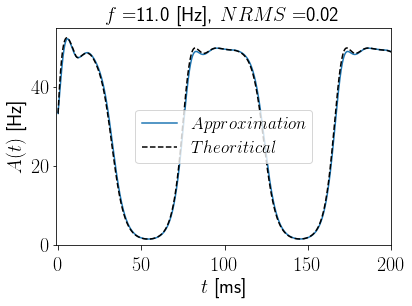

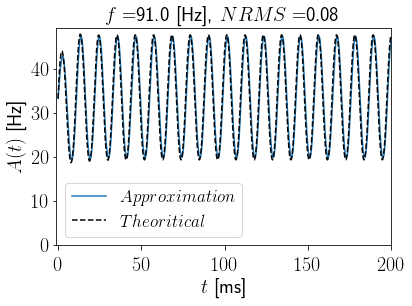

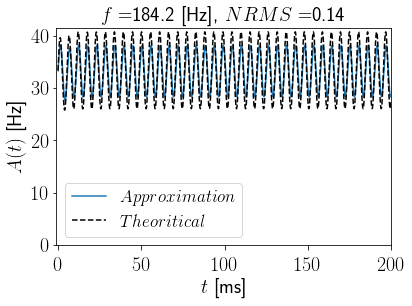

In [104]:
for i_o in [20,29,32]:
    for i_e, epsilon in enumerate(epsilon_vec):
        plt.figure()
        plt.plot(tsim,1000*A_Matrix[i_o,i_e,:],label='$Approximation$')
        plt.plot(tsim,1000*A_wc_Matrix[i_o,i_e,:],label='$Theoritical$',c='k',ls='--')
        plt.title(r'$f=$'+str(np.round(1000*fr_vec[i_o],1))+' [Hz], $NRMS=$'+str(np.round(NRMS_matrix[i_o,i_e],2)))
        #, $\epsilon=$'+str(epsilon)+ r' [mV] $
        plt.legend()
        plt.ylabel(r'$A(t)$ [Hz]')
        plt.xlabel(r'$t$ [ms]')
        plt.xlim(-1,t_max)
        plt.gca().set_ylim(bottom=0)

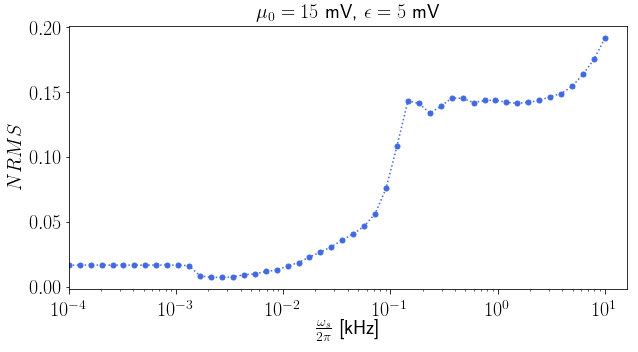

In [31]:


plt.figure(figsize=(10, 5))
colorv=['royalblue','g','r']
for i_e, epsilon in enumerate(epsilon_vec):
    plt.semilogx(fr_vec,NRMS_matrix[:,i_e],ls=':',marker='o',ms='5',c=colorv[i_e])#,label=r'$\epsilon=$'+str(epsilon)+r' $mV$')
plt.ylabel(r'$NRMS$ ')
plt.xlabel(r'$\frac{\omega_s}{2\pi}$ [kHz]')
plt.title(r'$\mu_0=15$ mV, $\epsilon=5 $ mV')

#plt.legend(loc='upper left',fontsize='20')

plt.xlim(0,16)

plt.gcf().subplots_adjust(bottom=0.15)

plt.savefig('NRMSo.pdf')

# effect of refractoriness

In [130]:
rate_1_Matrix=np.zeros((len(mu1_vec),len(epsilon_vec),N_sim))
rate_2_Matrix=np.zeros((len(mu1_vec),len(epsilon_vec),N_sim))

for i_o, mu_1 in enumerate(mu1_vec):
    for i_e, epsilon in enumerate(epsilon_vec):
        
        
        def mu(t):
            return mu_1 + epsilon/3*(np.cos(w1*t+ph1)+np.cos(w2*t+ph2)*np.cos(w3*t+ph3))
            
        
        print(i_o,i_e)
        # H PARMETER
        h=np.zeros((N_sim+1,1))

        h[0]=h_0  
        tau_m=5 #ms

        #NU PARAMETER
        beta=1 # mV^{-1}
        nu_0=phih(h[0],nu_max,beta,h_0)
        
    
        rate_1=np.zeros((N_sim,1))
        rate_2=np.zeros((N_sim,1))

        for i in range(N_sim):
            t=i*dt
    
    
            hpoint=1/tau_m*(-h[i]+mu(i*dt))
        

            h[i+1]=h[i]+dt*hpoint
            nu=phih(h[i],nu_max,beta,h_0)
            
            rate_1[i]=(nu_max/(1+d*nu_max))/(1+np.exp(-beta*(h[i]-h_0)))
            rate_2[i]=phih(h[i],nu_max,beta,h_0)/(1+d*phih(h[i],nu_max,beta,h_0))
        
        rate_1_Matrix[i_o,i_e,:]=rate_1.flatten()
        rate_2_Matrix[i_o,i_e,:]=rate_2.flatten()
        

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14


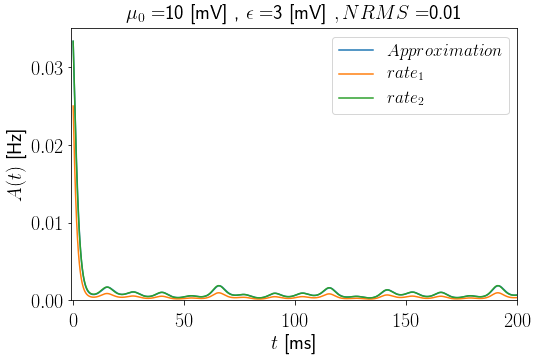

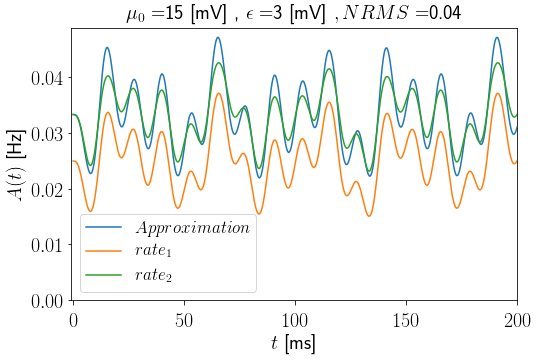

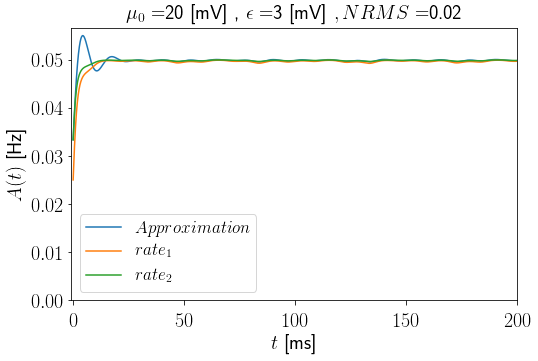

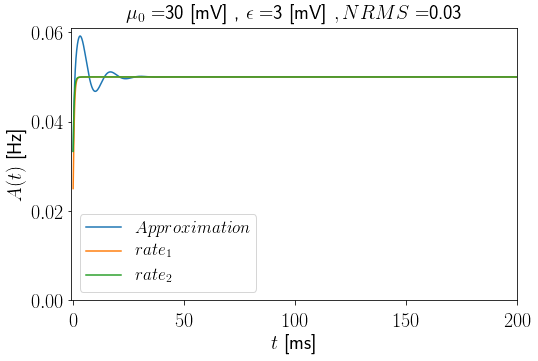

In [147]:
for i_o, mu_1 in enumerate(mu1_vec):
    i_e=2
    plt.figure()
    plt.plot(tsim,A_Matrix[i_o,i_e,:],label='$Approximation$')
    #plt.plot(tsim_num,A_wc_Matrix[i_o,i_e,:],label='$Theoritical$',c='k',ls='--')
    plt.plot(tsim,rate_1_Matrix[i_o,i_e,:],label='$rate_1$')
    plt.plot(tsim,rate_2_Matrix[i_o,i_e,:],label='$rate_2$')
    plt.title(r'$\mu_{0}=$'+str(mu1_vec[i_o])+' [mV] , $\epsilon=$'+str(epsilon_vec[i_e])+ r' [mV] $, NRMS=$'+str(np.round(NRMS_matrix[i_o,i_e],2)))

    plt.legend()
    plt.ylabel(r'$A(t)$ [Hz]')
    plt.xlabel(r'$t$ [ms]')
    plt.xlim(-1,t_max)
    plt.gca().set_ylim(bottom=0)

# COUPLED NETWORK

COMPARISON OF MATTIA and the found equation

In [13]:
def hpoint_f(h,tau_m,J,A_inf,U,V,phi1_0,t):
    return -h/tau_m + J/tau_m*(A_inf +2*(U*phi1_0.real-V*phi1_0.imag))+ mu(t)/tau_m
    
def f(l1,h,h_0,d,nu_max,beta,hpoint):
    return l1+(Cnm(1,1,h,nu_max,beta,h_0,d)+Cnm(1,-1,h,nu_max,beta,h_0,d))*hpoint

def g(l1,h,h_0,d,nu_max,beta,hpoint):
    return l1+(Cnm(1,1,h,nu_max,beta,h_0,d)-Cnm(1,-1,h,nu_max,beta,h_0,d))*hpoint
       

def c10(h,nu_max,beta,h_0,d,hpoint):
    return Cnm(1,0,h,nu_max,beta,h_0,d)*hpoint

def KLM(h,U,V,h_0,tau_m,J,d,nu_max,beta,t):
    
    nu=phih(h,nu_max,beta,h_0)
    
    l1=eigenvalue(1,nu,d)
    
    phi1_0= phi1_0h(h,nu_max,beta,h_0,d)

    A_inf=nu/(d*nu+1)
    
    hpoint=hpoint_f(h,tau_m,J,A_inf,U,V,phi1_0,t)
    
    ff=f(l1,h,h_0,d,nu_max,beta,hpoint)
    gg=g(l1,h,h_0,d,nu_max,beta,hpoint)
    cc=c10(h,nu_max,beta,h_0,d,hpoint)
    
    K_=K(ff,gg,cc,U,V)
    L_=L(ff,gg,cc,U,V)
    M_=M(h,tau_m,J,A_inf,U,V,phi1_0,t)
    
    return K_,L_,M_


def K(f,g,c,U,V):
    
    return (f.real*U-g.imag*V+c.real)

def L(f,g,c,U,V):
    return (g.real*V+f.imag*U+c.imag) 

def M(h,tau_m,J,A_inf,U,V,phi1_0,t):

    return -h/tau_m + J/tau_m*(A_inf +2*(U*phi1_0.real-V*phi1_0.imag))+ mu(t)/tau_m
    

# MATTIA

In [14]:
def dhdA_f(t,J,tau_m,x,y,h):
    return J

def dhdt_f(h,tau_m,J,x,t):
    return -h/tau_m + J/tau_m*x + mu(t)/tau_m

def C10_f(h,l1,nu,nu_max,beta,h_0,d):
    return (l1*(nu))/(l1*nu*(l1+nu)*(1+d*nu))*phih_prime(h,nu_max,beta,h_0)

def phi1_0_f(l1,nu,d):
    return (nu+l1)/(1+d*(nu+l1))

def phi0_0dh_f(nu,d,h,nu_max,beta,h_0):
    return phih_prime(h,nu_max,beta,h_0)/(1+d*nu)**2


In [15]:
def fun(z, t,nu_max,beta,h_0,d,tau_m,J):
    
    x, y, h = z
    
    nu=phih(h,nu_max,beta,h_0)
    
    l1=eigenvalue(1,nu,d)
    l1_=np.conjugate(l1)
  
    phi0_0=nu/(1+d*nu)
    
    phi1_0=phi1_0_f(l1,nu,d)
    
    C10=C10_f(h,l1,nu,nu_max,beta,h_0,d)
    
    fc=(2*phi1_0*C10).real
    flc=(2*phi1_0*C10*l1).real
    
    dhdt=dhdt_f(h,tau_m,J,x,t)
    
    phi0_0dh=phi0_0dh_f(nu,d,h,nu_max,beta,h_0)
    
    l1l1_=(l1*l1_).real
   
    dh2dht2=-dhdt/tau_m+J*y/tau_m
    
    
    ypoint= dh2dht2*(phi0_0dh+fc)+l1l1_*(phi0_0-x)+(2*l1.real)*(y-(phi0_0dh+fc)*dhdt)+flc*dhdt
    

    
    
    return np.array([y,ypoint,dhdt])




### Starting with a delta

In [16]:
#REFRACTORINESS
d=2

#TIME PARAMETER
dt=0.01

t_max=50
N_sim=int(t_max/dt)
tsim=[i*dt for i in range(N_sim)]
tsim_num=[i*dt for i in range(N_sim)]


#NU PARAMETER 
beta=0.5
nu_max=1

mu_0=5

def mu(t):
    return mu_0
     
# H PARMETER
h_0=mu_0
tau_m=10
J=0
    

In [17]:
A=np.zeros((N_sim,1))

h=np.zeros((N_sim+1,1))
h[0]=mu_0

h_wc=np.zeros((N_sim+1,1))
h_wc[0]=mu_0


#nu_0=phih(h[0],nu_max,beta,h_0)
#l1=eigenvalue(1,nu0,d)


U=np.zeros((N_sim+1,1))
U[0]=1

V=np.zeros((N_sim+1,1))
V[0]=0


A_wc=np.zeros((N_sim+1,1))
#nu_0=phih(h[0],nu_max,beta,h_0)
A_wc[0]=1/dt #nu_0/(1+d*nu_0)


d_index=int(d/dt)

for i in range(N_sim):
    t=i*dt
    
    if i<d_index:
        jstart=0
        #first_A=d_index-i-1
        first_A=0
    else:
        jstart=i-d_index+1
        first_A=0
    
    K1,L1,M1=KLM((h[i]),(U[i]),(V[i]),h_0,tau_m,J,d,nu_max,beta,t)
    
    K2,L2,M2=KLM((h[i]+0.5*dt*M1),(U[i]+0.5*dt*K1),(V[i]+0.5*dt*L1),h_0,tau_m,J,d,nu_max,beta,t)
        
    K3,L3,M3=KLM((h[i]+0.5*dt*M2),(U[i]+0.5*dt*K2),(V[i]+0.5*dt*L2),h_0,tau_m,J,d,nu_max,beta,t)
    
    K4,L4,M4=KLM((h[i]+dt*M3),(U[i]+dt*K3),(V[i]+dt*L3),h_0,tau_m,J,d,nu_max,beta,t)
    
    U[i+1]=U[i]+dt/6*(K1+2*K2+2*K3+K4)
    V[i+1]=V[i]+dt/6*(L1+2*L2+2*L3+L4)
    h[i+1]=h[i]+dt/6*(M1+2*M2+2*M3+M4)
    
    nu=phih(h[i],nu_max,beta,h_0)
    l1=eigenvalue(1,nu,d)
    phi1_0= phi1_0h(h[i],nu_max,beta,h_0,d)
    A_inf=nu/(d*nu+1)
    
    
    A[i]=A_inf+2*(U[i]*phi1_0.real-V[i]*phi1_0.imag)
    
    h_wc[i+1]=(1-dt/tau_m)*h_wc[i]+dt*J*A_wc[i]/tau_m+dt*mu(t)/tau_m
    nu_wc=phih(h_wc[i],nu_max,beta,h_0)
    A_wc[i+1]=nu_wc*(1-(np.sum(A_wc[jstart:i+1])+first_A*A_wc[0])*dt)
   
A_wc=A_wc[:-1]

In [18]:
nu_0=phih(h_0,nu_max,beta,h_0)

l1=eigenvalue(1,nu_0,d)
A0=nu_0/(1+d*nu_0)+2*((nu+l1)/(1+d*(nu+l1))).real
Apoint0=2*(l1*(nu+l1)/(1+d*(nu+l1))).real


print(A0,Apoint0)


dt_sol=0.01
t = np.linspace(0, t_max, num=np.int(t_max/dt_sol))


sol = odeint(fun, [A0,Apoint0,h_0], t, args=(nu_max,beta,h_0,d,tau_m,J))[..., 0]



[ 1.22808681] [-1.24413287]


(0, 20)

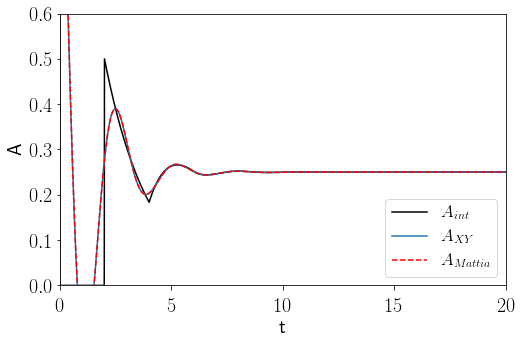

In [19]:

plt.figure()
plt.plot(tsim_num,A_wc,label='$A_{int}$',c='k',ls='-')
plt.plot(tsim,A,label='$A_{XY}$')

plt.plot(t,sol,label='$A_{Mattia}$',c='r',ls='--')
plt.legend()
plt.ylabel('A')
plt.xlabel('t')
plt.ylim(0,0.6)
plt.xlim(0,20)

### with coupling

In [20]:
def hpoint_f(h,tau_m,J,A_inf,U,V,phi1_0,t):
    return -h/tau_m + J/tau_m*(A_inf +2*(U*phi1_0.real-V*phi1_0.imag))+ mu(t)/tau_m
    
def f(l1,h,h_0,d,nu_max,beta,hpoint):
    return l1+(Cnm(1,1,h,nu_max,beta,h_0,d)+Cnm(1,-1,h,nu_max,beta,h_0,d))*hpoint


def g(l1,h,h_0,d,nu_max,beta,hpoint):
    return l1+(Cnm(1,1,h,nu_max,beta,h_0,d)-Cnm(1,-1,h,nu_max,beta,h_0,d))*hpoint

       

def c10(h,nu_max,beta,h_0,d,hpoint):
    return Cnm(1,0,h,nu_max,beta,h_0,d)*hpoint

def KLM(h,U,V,h_0,tau_m,J,d,nu_max,beta,t):
    
    nu=phih(h,nu_max,beta,h_0)
    
    l1=eigenvalue(1,nu,d)
    
    phi1_0= phi1_0h(h,nu_max,beta,h_0,d)

    A_inf=nu/(d*nu+1)
    
    hpoint=hpoint_f(h,tau_m,J,A_inf,U,V,phi1_0,t)
    
    ff=f(l1,h,h_0,d,nu_max,beta,hpoint)
    gg=g(l1,h,h_0,d,nu_max,beta,hpoint)
    cc=c10(h,nu_max,beta,h_0,d,hpoint)
    
    K_=K(ff,gg,cc,U,V)
    L_=L(ff,gg,cc,U,V)
    M_=M(h,tau_m,J,A_inf,U,V,phi1_0,t)
    
    
    return K_,L_,M_


def KLM_simple(h,U,V,h_0,tau_m,J,d,nu_max,beta,t):
    
    nu=phih(h,nu_max,beta,h_0)
    
    l1=eigenvalue(1,nu,d)
    
    phi1_0= phi1_0h(h,nu_max,beta,h_0,d)

    A_inf=nu/(d*nu+1)
    
    hpoint=hpoint_f(h,tau_m,J,A_inf,U,V,phi1_0,t)
    
    ff=l1
    gg=l1
    cc=c10(h,nu_max,beta,h_0,d,hpoint)
    
    K_=K(ff,gg,cc,U,V)
    L_=L(ff,gg,cc,U,V)
    M_=M(h,tau_m,J,A_inf,U,V,phi1_0,t)
    
    return K_,L_,M_


def K(f,g,c,U,V):
    
    return (f.real*U-g.imag*V+c.real)

def L(f,g,c,U,V):
    return (g.real*V+f.imag*U+c.imag) 

def M(h,tau_m,J,A_inf,U,V,phi1_0,t):

    return -h/tau_m + J/tau_m*(A_inf +2*(U*phi1_0.real-V*phi1_0.imag))+ mu(t)/tau_m
    



In [21]:
#REFRACTORINESS
d=2

#TIME PARAMETER
dt=0.01

t_max=100
N_sim=int(t_max/dt)
tsim=[i*dt for i in range(N_sim)]
tsim_num=[i*dt for i in range(N_sim)]

#NU PARAMETER 
beta=0.5
nu_max=1

#MU 
mu_0=-1
mu_1=-32
mu_2=+10
mu_3=-10

def mu(t):
    if t<20:
        return mu_0
    elif t<40:
        return mu_1
    elif t<60:
        return mu_2
    else:
        return mu_3
     
# H PARMETER
h_0=mu_0
tau_m=10
J=100   

In [22]:
A=np.zeros((N_sim,1))

U=np.zeros((N_sim+1,1))
U[0]=0

V=np.zeros((N_sim+1,1))
V[0]=0

h=np.zeros((N_sim+1,1))
h[0]=mu_0

h_wc=np.zeros((N_sim+1,1))
h_wc[0]=mu_0


A_wc=np.zeros((N_sim+1,1))
nu_0=phih(h[0],nu_max,beta,h_0)
A_wc[0]=nu_0/(1+d*nu_0)


d_index=int(d/dt)

for i in range(N_sim):
    t=i*dt
    
    
    if i<d_index:
        jstart=0
        first_A=d_index-i-1
    else:
        jstart=i-d_index+1
        first_A=0
    
    K1,L1,M1=KLM((h[i]),(U[i]),(V[i]),h_0,tau_m,J,d,nu_max,beta,t)
    
    K2,L2,M2=KLM((h[i]+0.5*dt*M1),(U[i]+0.5*dt*K1),(V[i]+0.5*dt*L1),h_0,tau_m,J,d,nu_max,beta,t)
        
    K3,L3,M3=KLM((h[i]+0.5*dt*M2),(U[i]+0.5*dt*K2),(V[i]+0.5*dt*L2),h_0,tau_m,J,d,nu_max,beta,t)
    
    K4,L4,M4=KLM((h[i]+dt*M3),(U[i]+dt*K3),(V[i]+dt*L3),h_0,tau_m,J,d,nu_max,beta,t)
    
    
    U[i+1]=U[i]+dt/6*(K1+2*K2+2*K3+K4)
    V[i+1]=V[i]+dt/6*(L1+2*L2+2*L3+L4)
    h[i+1]=h[i]+dt/6*(M1+2*M2+2*M3+M4)
    
    
    nu=phih(h[i],nu_max,beta,h_0)
    l1=eigenvalue(1,nu,d)
    phi1_0= phi1_0h(h[i],nu_max,beta,h_0,d)
    A_inf=nu/(d*nu+1)
    
    
    A[i]=A_inf+2*(U[i]*phi1_0.real-V[i]*phi1_0.imag)
    
    h_wc[i+1]=(1-dt/tau_m)*h_wc[i]+dt*J*A_wc[i]/tau_m+dt*mu(t)/tau_m
    nu_wc=phih(h_wc[i],nu_max,beta,h_0)
    A_wc[i+1]=nu_wc*(1-(np.sum(A_wc[jstart:i+1])+first_A*A_wc[0])*dt)
   
A_wc=A_wc[:-1]

Simple

In [23]:
A_simple=np.zeros((N_sim,1))

U=np.zeros((N_sim+1,1))
U[0]=0

V=np.zeros((N_sim+1,1))
V[0]=0

h=np.zeros((N_sim+1,1))
h[0]=mu_0


d_index=int(d/dt)

for i in range(N_sim):
    t=i*dt
    
    
    K1,L1,M1=KLM_simple((h[i]),(U[i]),(V[i]),h_0,tau_m,J,d,nu_max,beta,t)
    
    K2,L2,M2=KLM_simple((h[i]+0.5*dt*M1),(U[i]+0.5*dt*K1),(V[i]+0.5*dt*L1),h_0,tau_m,J,d,nu_max,beta,t)
        
    K3,L3,M3=KLM_simple((h[i]+0.5*dt*M2),(U[i]+0.5*dt*K2),(V[i]+0.5*dt*L2),h_0,tau_m,J,d,nu_max,beta,t)
    
    K4,L4,M4=KLM_simple((h[i]+dt*M3),(U[i]+dt*K3),(V[i]+dt*L3),h_0,tau_m,J,d,nu_max,beta,t)
    
    
    U[i+1]=U[i]+dt/6*(K1+2*K2+2*K3+K4)
    V[i+1]=V[i]+dt/6*(L1+2*L2+2*L3+L4)
    h[i+1]=h[i]+dt/6*(M1+2*M2+2*M3+M4)
    
    
    
    
    nu=phih(h[i],nu_max,beta,h_0)
    l1=eigenvalue(1,nu,d)
    phi1_0= phi1_0h(h[i],nu_max,beta,h_0,d)
    A_inf=nu/(d*nu+1)
    
    
    A_simple[i]=A_inf+2*(U[i]*phi1_0.real-V[i]*phi1_0.imag)
    

Mattia

In [45]:
nu_0=phih(mu_0,nu_max,beta,h_0)
A0=nu_0/(1+d*nu_0)

l1=eigenvalue(1,nu_0,d)

phi1_0_0=phi1_0_f(l1,nu_0,d)
    
C10_0=C10_f(h_0,l1,nu_0,nu_max,beta,h_0,d)
    
fc_0=(2*phi1_0*C10_0).real


Apoint0= (phi0_0dh_f(nu_0,d,h_0,nu_max,beta,h_0)+fc_0)*dhdt_f(h_0,tau_m,J,A0,0)
    


print(A0,Apoint0)

dt_sol=0.001
t = np.linspace(0, t_max, num=np.int(t_max/dt_sol))


sol = odeint(fun, [A0,Apoint0,h_0], t, args=(nu_max,beta,h_0,d,tau_m,J))[..., 0]



0.25 [ 0.08248767]


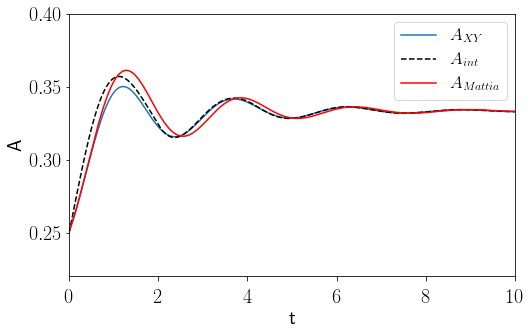

In [46]:

plt.figure()
plt.plot(tsim,A,label='$A_{XY}$')
#plt.plot(tsim,A_simple,label='$AS_{XY}$')
plt.plot(tsim_num,A_wc,label='$A_{int}$',c='k',ls='--')
plt.plot(t,sol,label='$A_{Mattia}$',c='r',ls='-')
plt.legend()
plt.ylabel('A')
plt.xlabel('t')
plt.xlim(0,10)
plt.ylim(0.22,0.4)
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig('mattia2.pdf')

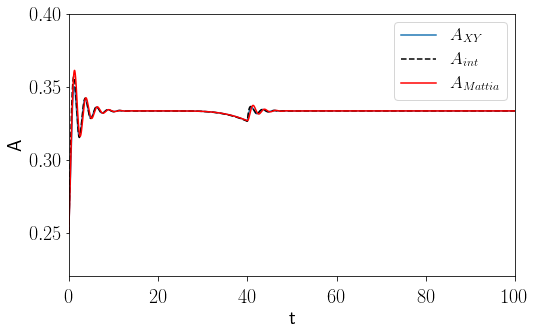

In [47]:

plt.figure()
plt.plot(tsim,A,label='$A_{XY}$')
#plt.plot(tsim,A_simple,label='$AS_{XY}$')
plt.plot(tsim_num,A_wc,label='$A_{int}$',c='k',ls='--')
plt.plot(t,sol,label='$A_{Mattia}$',c='r',ls='-')
plt.legend()
plt.ylabel('A')
plt.xlabel('t')
plt.xlim(0,100)
plt.ylim(0.22,0.4)
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig('mattia1.pdf')

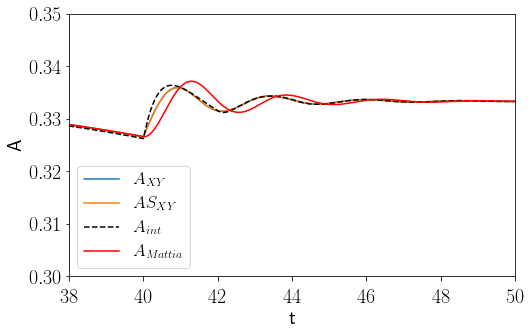

In [51]:

plt.figure()
plt.plot(tsim,A,label='$A_{XY}$')
plt.plot(tsim,A_simple,label='$AS_{XY}$')
plt.plot(tsim_num,A_wc,label='$A_{int}$',c='k',ls='--')
plt.plot(t,sol,label='$A_{Mattia}$',c='r',ls='-')
plt.legend()
plt.ylabel('A')
plt.xlabel('t')
plt.xlim(38,50)
plt.ylim(0.3,0.35)
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig('mattia1.pdf')